
No GPU found, using CPU.
Found 20001 images belonging to 2 classes.
Found 4997 images belonging to 2 classes.



Epoch 1/30


314/626 [==============>...............] - ETA: 10:48 - loss: 0.3057 - accuracy: 0.8775

C:\Users\Emage Vision\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


626/626 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8896

C:\Users\Emage Vision\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


626/626 [==============================] - 1605s 3s/step - loss: 0.2719 - accuracy: 0.8896 - val_loss: 0.1885 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 2/30
626/626 [==============================] - 1570s 3s/step - loss: 0.2054 - accuracy: 0.9131 - val_loss: 0.2624 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 3/30
626/626 [==============================] - 1596s 3s/step - loss: 0.1937 - accuracy: 0.9190 - val_loss: 0.1807 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 4/30
626/626 [==============================] - 1597s 3s/step - loss: 0.1868 - accuracy: 0.9229 - val_loss: 0.1790 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 5/30
626/626 [==============================] - 1576s 3s/step - loss: 0.1800 - accuracy: 0.9261 - val_loss: 0.1752 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 6/30
626/626 [==============================] - 1576s 3s/step - loss: 0.1785 - accuracy: 0.9276 - val_loss: 0.1681 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 7/30
626/626 [==============================] - 1581s 3s/step -

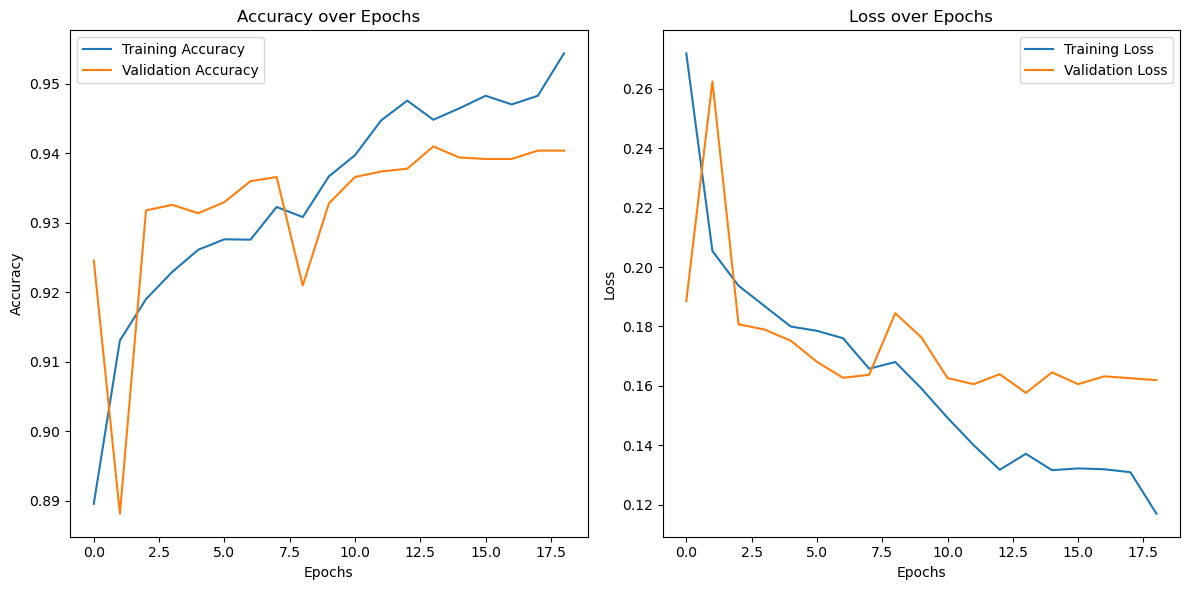

Best model loaded successfully.
1/1 [==============================] - 0s 107ms/step


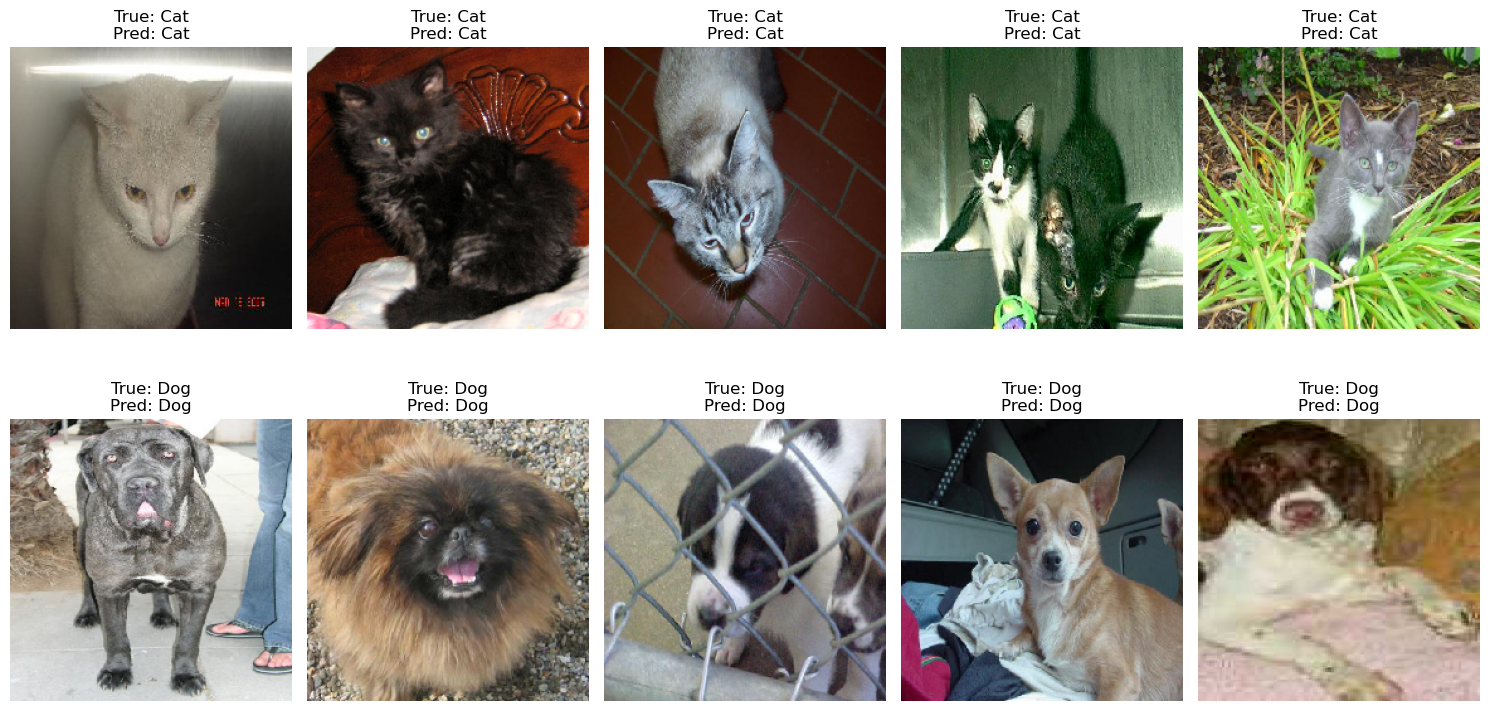

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os

# 1. Check and set GPU configurations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid TensorFlow allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are set up and memory growth is enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

# 2. Set up Data Augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)

# 3. Load the training and validation datasets 
train_generator = train_datagen.flow_from_directory(
    'F:/Data sets/Dog vs cat/PetImages/train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    'F:/Data sets/Dog vs cat/PetImages/validation', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 4. Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the pre-trained model
base_model.trainable = False

# 5. Build the full model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),  # Batch normalization for better training stability
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification (Dog vs Cat)
])

# 6. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# 8. Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

# 9. Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# 10. Plotting the training and validation accuracy and loss
# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 11. Save the final model (optional)
model.save('Dog&cat_model.h5')

# 12. Load the Best Model Saved by ModelCheckpoint
best_model = load_model('best_model.h5')
print("Best model loaded successfully.")

# 13. Function to Display Random Dog and Cat Images
def display_images_with_predictions(dataset_path, num_images=5):
    """
    Displays random dog and cat images along with predictions.
    
    Args:
        dataset_path (str): Path to the dataset directory.
        num_images (int): Number of images to display per class.
    """
    # Define classes
    classes = ['Cat', 'Dog']
    
    # Get random image paths for each class
    cat_images = [os.path.join(dataset_path, 'Cat', img) for img in os.listdir(os.path.join(dataset_path, 'Cat'))]
    dog_images = [os.path.join(dataset_path, 'Dog', img) for img in os.listdir(os.path.join(dataset_path, 'Dog'))]
    
    # Randomly select images
    np.random.shuffle(cat_images)
    np.random.shuffle(dog_images)
    
    selected_images = cat_images[:num_images] + dog_images[:num_images]
    labels = [0] * num_images + [1] * num_images  # 0 for Cat, 1 for Dog
    
    # Plot images and predictions
    plt.figure(figsize=(15, 8))
    for i, img_path in enumerate(selected_images):
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict the class
        prediction = best_model.predict(img_array)
        predicted_class = int(prediction[0][0] >= 0.5)  # Threshold at 0.5
        
        # Display the image with prediction
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPred: {classes[predicted_class]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 14. Call the Function to Display Images
dataset_path = 'F:/Data sets/Dog vs cat/PetImages/train'  
display_images_with_predictions(dataset_path, num_images=5)